# Comparing HSIC versus Mutual Information measures

In this notebook, we will be exploring how we can estimate the HSIC parmaeter for different distributions and look at how it compares to MI measures. Normally the procedure for calculating HSIC is as follows:

1. Calculate kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices

This works well but there is no certain way to estimate the parameter for each of the kernel matrices. There is another paper that is called the Kernel Tangent Alignment (KTA). This method is different as it is calculated like so:

1. Calculate the kernel matrices for X and Y
2. Find the Frobenius norm between the kernel matrices
3. Normalize the value by the Frobenius norm of X and Y individually

This works in a similar way to the HSIC method. The difference is that you do the normalization procedure. The final algorithm is the Centered Kernel Tangent Alignment (cKTA) method which is a combination of the previous two methods. The algorithm is as follows:

1. Calculate the kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices
4. Normalize the value by the Frobenius norm of X and Y individually 

As you can see, it would appear that this method is the most complete in the sense that it incorporates all steps to ensure that our data is sufficiently scaled to a way that is directly comparable. This notebook will attempt to see which of these methods provides a good estimate for a sigma value for the kernel matrices and how do their output values compare to mutual information measures.

## Code

In [1]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
# from models.dependence import HSIC, train_hsic
# from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

In [62]:
from pysim.kernel.hsic import HSIC
from pysim.kernel.utils import get_init_gammas

## Example

### Data

No handles with labels found to put in legend.


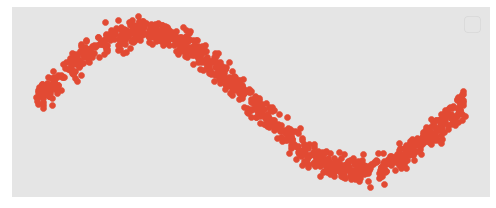

In [2]:
# data params
dataset = 'sine'
num_points = 1000
seed = 123
noise_x = 0.1
noise_y = 0.1

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y
)

X_scale, Y_scale = X * 1, Y * 1
# plot

fig, ax = plt.subplots(nrows=1, figsize=(7, 3))

ax.scatter(X, Y)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_aspect('equal', 'box')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/datasets/'
fig.savefig(f"{save_path}demo_{dataset}.png")

### HSIC Value

#### Original HSIC Value

In [12]:
# hsic params
kernel = 'rbf'
center = True
normalize = False
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    center=center,
    normalized=normalized,
    subsample=subsample,
    bias=bias
)

# calculate HSIC return scorer
clf_hsic.fit(X_scale, Y_scale);

# hsic value and kernel alignment score
hsic_val = clf_hsic.score(X, normalize=normalize)

print(f"HSIC: {hsic_val:.5f}")

HSIC: 0.02719


#### Kernel Tangent Alignment

In [13]:
# hsic params
kernel = 'rbf'
center = False
normalize = True
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    center=center,
    normalized=normalized,
    subsample=subsample,
    bias=bias
)


# calculate HSIC return scorer
clf_hsic.fit(X, Y);

# hsic value and kernel alignment score
ka_val = clf_hsic.score(X, normalize=normalize)

print(f"KA: {ka_val:.5f}")

KA: 0.87495


#### Centered Kernel Tangent Alignment

In [14]:
# hsic params
kernel = 'rbf'
center = True
normalize = True
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    center=center,
    normalized=normalized,
    subsample=subsample,
    bias=bias
)


# calculate HSIC return scorer
clf_hsic.fit(X, Y);

# hsic value and kernel alignment score
cka_val = clf_hsic.score(X, normalize=normalize)

print(f"CKA: {cka_val:.5f}")

CKA: 0.65111


### Problem Example

So here I will demonstrate one of the problems with trying to use HSIC without proper consideration of the parameters. I will vary the gamme value from 0.001 to 1000 and we'll see that the values for HSIC and cKTA will change depending upon the parameters.

In [7]:
from typing import Optional

FIG_PATH = f'{cwd}/../../results/figures/init_gamma/'
def plot_max_hsic(results_list, scorer='hsic', function='line', sigma_est='mean', save=True, plot_legend=True):
    
    save_path = f'{cwd}/../../results/figures/init_gamma/'
    
    fig, ax = plt.subplots(nrows=1, figsize=(7, 5))
    
    # MAX HSIC Values
    max_idx = np.argmax(scorers[scorer])
    hsic_max = scorers[scorer][max_idx]
    gamma_max = gammas[max_idx]
    print(f'Max {scorer.upper()}: {hsic_max:.4f}')
    print(f'Max Gamma ({scorer.upper()}): {gamma_max:.4f}\n')

    # init HSIC Values
    init_median, _ = get_init(method='median', factor=1)
    median_hsic = HSIC(gamma_X=init_median, scorer=scorer).fit(X, Y).score(X)
#     print(init_median, median_hsic)
    
    init_mean, _ = get_init(method='mean', factor=1)
    mean_hsic = HSIC(gamma_X=init_mean, scorer=scorer).fit(X, Y).score(X)
#     print(init_mean, mean_hsic)
    
    init_silv, _ = get_init(method='silverman', factor=1)
    silv_hsic = HSIC(gamma_X=init_silv, scorer=scorer).fit(X, Y).score(X)
#     print(init_silv, silv_hsic)

    ax.set_xscale('log')
    ax.plot(gammas, scorers[scorer], color='red', linewidth=10, zorder=0)
    ax.scatter(gamma_max, hsic_max, s=300, c='yellow', label=f'Maximum', zorder=1)
    ax.scatter(init_median, median_hsic, s=300, c='black', label='Median', zorder=1)
    ax.scatter(init_mean, mean_hsic, s=300, c='green', label='Mean', zorder=1)
    ax.scatter(init_silv, silv_hsic, s=300, c='blue', label='Silverman', zorder=1)
    ax.set_xlabel('$\gamma$', fontsize=20)
    ax.set_ylabel(f'{scorer.upper()}', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    if scorer in ['ctka', 'tka']:
        ax.set_ylim([0.0, 1.1])
    elif scorer in ['hsic']:
        ax.set_ylim([0.0, 0.11])
    else:
        raise ValueError(f"Unrecognized scorer: {scorer}")
    if not plot_legend: 
        plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()
    
#     if save:
    save_name = f"demo_{function}_{sigma_est}_{scorer}"
    fig.savefig(save_path + save_name + ".png")

    # plot legend
    # colors = [c for c in handles.]
    handles, labels = ax.get_legend_handles_labels()
    if plot_legend:
        plot_legend_alone(handles, labels, save_name)


def plot_legend_alone(handles, labels, save_name: Optional[str] = None):
    fig_legend = plt.figure(constrained_layout=True)
    ax = fig_legend.add_subplot(111)
    fig_legend.legend(
        handles, labels, loc="upper center", frameon=False, ncol=len(labels)
    )
    # ax.axis("off")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig_legend.canvas.draw()
    plt.tight_layout()
    # bbox_inches = "tight"
    # plt.tight_layout()

    if save_name is not None:
        fig_legend.savefig(FIG_PATH + save_name + "_legend.png", bbox_inches="tight")
    fig_legend.show()

In [68]:
init_gamma, gammas = get_init(sigma_est, factor=factor, percent=0.5, n_gammas=n_gammas)

In [69]:
init_gamma

7.451958123570317

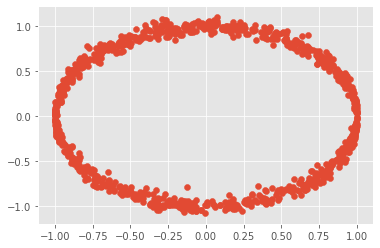

In [82]:
# Generate data
dataset = 'circle'
num_points = 1_000
noise_x = 0.05
noise_y = 0.05
seed = 1


X, Y = generate_dependence_data(
    dataset=dataset, 
    num_points=num_points,
    noise_x=noise_x,
    noise_y=noise_y,
    seed=seed
)

plt.scatter(X,Y)

In [84]:
# hsic model params
kernel = 'rbf'
subsample = None
bias = True
scorer = 'hsic'
sigma_est = 'max'

init_gamma, gammas = get_init(sigma_est, factor=factor, percent=None, n_gammas=n_gammas)
print(init_gamma)

clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer,
    gamma_X=igamma,
    subsample=subsample,
    bias=bias
)

# calculate HSIC return scorer
clf_hsic.fit(X, Y);
print(clf_hsic.score(X))

ValueError: Unrecognized mode "max".

### Experiment Step

In [51]:
def get_init(X, Y, method='median', factor=1, percent=None, scale=1.0, n_gammas=100):
    
    # estimate sigma params
    factor = 1
    n_gammas = 100

    # Estimate Sigma
    sigma_x = estimate_sigma(X, method=method, percent=percent, scale=scale)
    sigma_y = estimate_sigma(Y, method=method, percent=percent, scale=scale)

    # init overall sigma is mean between two
    init_sigma = np.mean([sigma_x, sigma_y])

    # get sigma parameter grid
    sigmas = get_param_grid(init_sigma, factor, n_gammas)


    gammas = sigma_to_gamma(sigmas)
    init_gamma = sigma_to_gamma(init_sigma)
    return init_gamma, gammas

In [87]:
def experiment_step(X, Y, step_params: dict, exp_params: dict, ):
    
    # Get HSIC Score
    clf_hsic = HSIC(
        kernel=step_params.kernel, 
        center=step_params.center,
        gamma_X=step_params.X_gamma,
        gamma_Y=step_params.Y_gamma,
        subsample=exp_params.subsample,
        bias=exp_params.bias
    )

    # calculate HSIC return scorer
    clf_hsic.fit(X, Y);

    # hsic value and kernel alignment score
    corr_score = clf_hsic.score(X, normalize=step_params.normalize)

    results_df = pd.DataFrame({
        'score': corr_score,
        'kernel': step_params.kernel,
        'dataset': step_params.dataset,
        'gamma_x': step_params.X_gamma,
        'gamma_y': step_params.Y_gamma,
        'center': step_params.center,
        'normalize': step_params.normalize,
        'trial': step_params.seed
    }, index=[0])
    return results_df

In [250]:
class ExperimentParams:
    # ====================
    # Dataset Params
    # ====================
    datasets = ['sine', 'line', 'circle', 'random']
    num_points = 1_000
    noise_x = 0.025
    noise_y = 0.025
    # ====================
    # Experiment Params
    # ====================
    seeds = np.linspace(1,10,10,dtype=int)
    sigma_est = 'median'
    factor = 1
    n_gammas = 10
    percent = 0.5
    # hsic model params
    kernels = ['rbf', 'linear']
    subsample = None
    bias = True
    normalize = [True, False]
    center = [True, False]
    save_name = 'test'


class StepParams:
    dataset = 'circle'
    kernel = 'rbf'
    center = True
    X_gamma = 1.0
    Y_gamma = 1.0
    normalize = True
    seed = 1
    init_gamma = 'median'
    
results_df = experiment_step(X, Y, StepParams, ExperimentParams)
results_df

,score,kernel,dataset,gamma_x,gamma_y,center,normalize,trial
0,0.65111,rbf,circle,1.0,1.0,True,True,1


In [251]:
SAVE_PATH = "/home/emmanuel/projects/2019_hsic_align/data/results/estimate/"
INTERIM_PATH = "/home/emmanuel/projects/2019_hsic_align/data/interim/estimate/"
def run_experiment(exp_params):
    

    
    results_df = pd.DataFrame()
    
    # Experimental Loop
    for idata in exp_params.datasets:
        print(f"Dataset: {idata}")
        for iseed in exp_params.seeds:
            print(f"Trial: {iseed}")
            for ikernel in exp_params.kernels:
                print(f"Kernel: {ikernel}")
                for icenter in exp_params.center:
                    for inormalize in exp_params.normalize:
                    
                        
                        # Extract Data
                        X, Y = generate_dependence_data(
                            dataset=idata, 
                            num_points=exp_params.num_points,
                            noise_x=exp_params.noise_x,
                            noise_y=exp_params.noise_y,
                            seed=iseed
                        )

                        # estimate sigma params
                        init_gamma, gammas = get_init_gammas(X, Y,
                            exp_params.sigma_est, 
                            factor=exp_params.factor, 
                            percent=exp_params.percent, 
                            n_gammas=exp_params.n_gammas
                        )
                        


                        # create step parameters

                        for igamma in gammas:
                            class StepParams:
                                dataset = idata
                                kernel = ikernel
                                center = icenter
                                gamma_init = init_gamma
                                X_gamma = igamma
                                Y_gamma = igamma
                                normalize = inormalize
                                seed = iseed
                            
                            
                            ires = experiment_step(
                                X, Y, 
                                StepParams, exp_params
                            )
                            results_df = results_df.append(ires, ignore_index=True)
                            results_df.to_csv(INTERIM_PATH + f"{exp_params.save_name}.csv")
    results_df.to_csv(SAVE_PATH + f"{exp_params.save_name}.csv")
    return results_df


In [ ]:
results_df = run_experiment(ExperimentParams)

Dataset: sine
Trial: 1
Kernel: rbf
Kernel: linear
Trial: 2
Kernel: rbf
Kernel: linear
Trial: 3
Kernel: rbf
Kernel: linear
Trial: 4
Kernel: rbf
Kernel: linear
Trial: 5
Kernel: rbf
Kernel: linear
Trial: 6
Kernel: rbf
Kernel: linear
Trial: 7
Kernel: rbf
Kernel: linear
Trial: 8
Kernel: rbf
Kernel: linear
Trial: 9
Kernel: rbf
Kernel: linear
Trial: 10
Kernel: rbf
Kernel: linear
Dataset: line
Trial: 1
Kernel: rbf
Kernel: linear
Trial: 2
Kernel: rbf
Kernel: linear
Trial: 3
Kernel: rbf
Kernel: linear
Trial: 4
Kernel: rbf
Kernel: linear
Trial: 5
Kernel: rbf
Kernel: linear
Trial: 6
Kernel: rbf
Kernel: linear
Trial: 7
Kernel: rbf
Kernel: linear
Trial: 8
Kernel: rbf
Kernel: linear
Trial: 9
Kernel: rbf
Kernel: linear
Trial: 10
Kernel: rbf
Kernel: linear
Dataset: circle
Trial: 1
Kernel: rbf
Kernel: linear
Trial: 2
Kernel: rbf
Kernel: linear
Trial: 3
Kernel: rbf
Kernel: linear
Trial: 4
Kernel: rbf
Kernel: linear
Trial: 5
Kernel: rbf
Kernel: linear
Trial: 6
Kernel: rbf
Kernel: linear
Trial: 7
Kernel: r

#### Plot I - Score Space

In [98]:
import seaborn as sns

##### Unnormalized, Centered (HSIC)

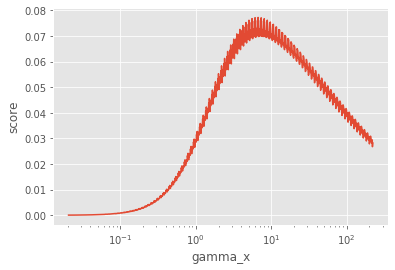

In [241]:
sub_df = results_df[results_df['kernel']=='rbf']
sub_df = sub_df[sub_df['dataset']=='sine']
sub_df = sub_df[sub_df['center']==True]
sub_df = sub_df[sub_df['normalize']==False]
sub_df = sub_df.drop(['gamma_y', 'normalize', 'center', 'dataset', 'kernel'], axis=1)

fig, ax = plt.subplots()

sns.lineplot(ax=ax, x='gamma_x', y='score', data=sub_df, )
ax.set(xscale="log", )
plt.show()

##### UnCentered, Unnormalized

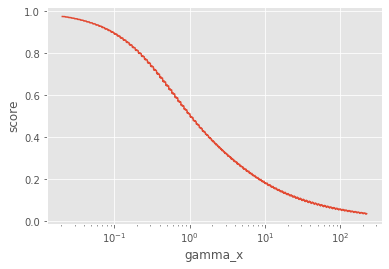

In [242]:
sub_df = results_df[results_df['kernel']=='rbf']
sub_df = sub_df[sub_df['dataset']=='sine']
sub_df = sub_df[sub_df['center']==False]
sub_df = sub_df[sub_df['normalize']==False]
sub_df = sub_df.drop(['gamma_y', 'normalize', 'center', 'dataset', 'kernel'], axis=1)

fig, ax = plt.subplots()

sns.lineplot(ax=ax, x='gamma_x', y='score', data=sub_df, )
ax.set(xscale="log", )
plt.show()

##### Uncentered, Normalized (KA)

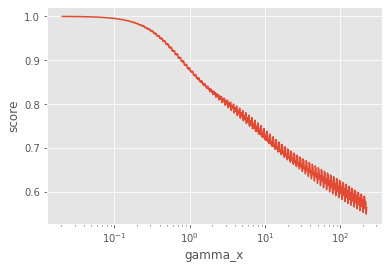

In [243]:
sub_df = results_df[results_df['kernel']=='rbf']
sub_df = sub_df[sub_df['dataset']=='sine']
sub_df = sub_df[sub_df['center']==False]
sub_df = sub_df[sub_df['normalize']==True]
sub_df = sub_df.drop(['gamma_y', 'normalize', 'center', 'dataset', 'kernel'], axis=1)

fig, ax = plt.subplots()

sns.lineplot(ax=ax, x='gamma_x', y='score', data=sub_df, )
ax.set(xscale="log", )
plt.show()

##### Normalized, Centered (cKA)

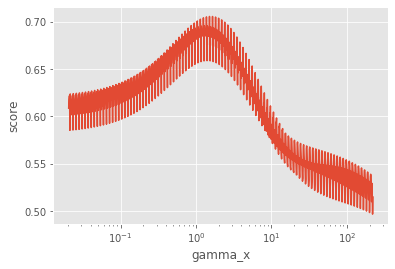

In [244]:
sub_df = results_df[results_df['kernel']=='rbf']
sub_df = sub_df[sub_df['dataset']=='sine']
sub_df = sub_df[sub_df['center']==True]
sub_df = sub_df[sub_df['normalize']==True]
sub_df = sub_df.drop(['gamma_y', 'normalize', 'center', 'dataset', 'kernel'], axis=1)

fig, ax = plt.subplots()

sns.lineplot(ax=ax, x='gamma_x', y='score', data=sub_df, )
ax.set(xscale="log", )
plt.show()

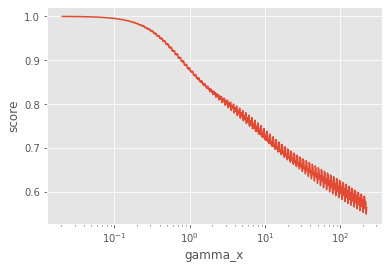

In [240]:
sub_df = results_df[results_df['kernel']=='rbf']
sub_df = sub_df[sub_df['dataset']=='sine']
sub_df = sub_df[sub_df['center']==False]
sub_df = sub_df[sub_df['normalize']==True]
sub_df = sub_df.drop(['gamma_y'], axis=1)

fig, ax = plt.subplots()

sns.lineplot(ax=ax, x='gamma_x', y='score', data=sub_df, )
ax.set(xscale="log", )
plt.show()

Max HSIC: 0.0691
Max Gamma (HSIC): 6.8922



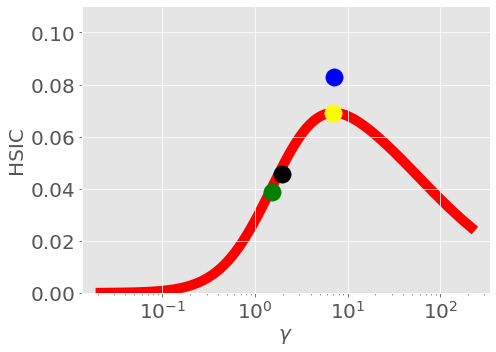

Max TKA: 0.9997
Max Gamma (TKA): 0.0215



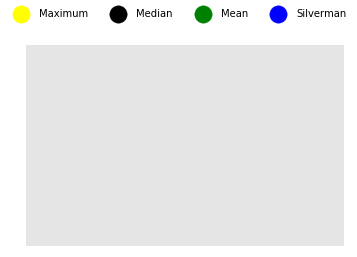

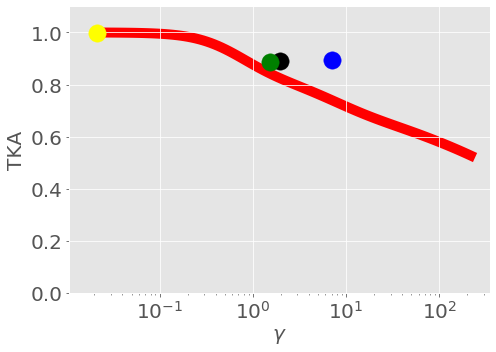

Max CTKA: 0.6639
Max Gamma (CTKA): 1.4174



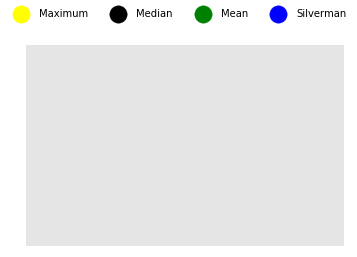

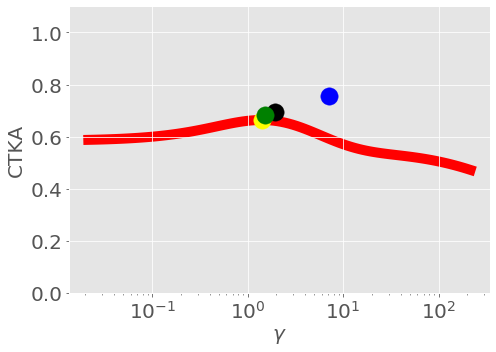

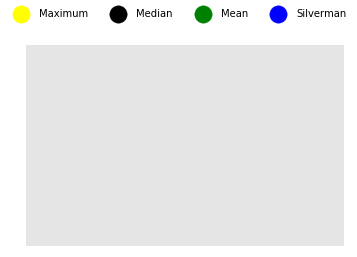

In [19]:
plot_max_hsic(scorers, 'hsic', dataset, sigma_est)
plot_max_hsic(scorers, 'tka', dataset, sigma_est)
plot_max_hsic(scorers, 'ctka', dataset, sigma_est)

So as you can see, there exists some space of gamma that would fit our problem and the actual value of HSIC and cKTA changes. I also don't see any direct correspondence between the two values. Neither really make sense. There is a maximum HSIC value but that doesn't necessarily mean it's the best one.